In [161]:
using Plots, Statistics, Printf
gr()

Plots.GRBackend()

In [2]:
function mslicer(g, dim, x0, xargs; N=1000, w=0.5, m=10)
    #=VERSION FOR VECTOR FIXES=#
    #= multi-D slice sampler, g: log of distribution function,
    dim number of dimensions
    x0: start (or next) point, values of distribution parameters. x1: next point.
    xargs: extra arguments for distribution, Nm samples to return,
        w: \"out step\" distance, m: max number of outward steps.
    Returns N x dim array.
    Steps successively in each direction in the sample space, so it produces
    dim*N samples as currently written.

    Note that you only have to worry about log scaling in 'vertical' comparisons
    in these Monte Carlo chain calculations.

    NOTE: this needs to be checked for the whole julia
    vector vs matrix thing: what is  [1 2 3] vs [1,2,3]?
    =#
    xs = zeros(N, dim)  # array that will be returned
    xs[1,:] = x0  #x0 should be array 1,dim; needs [1.0 1.0] syntax for this version.
    #print(x0)
    x1 = zeros(1,dim)
    L = zeros(1,dim)
    R = zeros(1,dim)
    way = zeros(1,dim)  # which axis to go along in space
    i = 2    # assumed start values for chain are recorded at xs[1,1]
    while i <= N
        for d in 1:dim       # go one step in each dimensional direction.
            way = 0.0 * way #clear it
            way[d] = 1.0 #set nonzero in direction we go for slicing on this step
            y0 = g(x0,xargs)  #height of distribution at x0
            y = y0 + log(rand()) # height for slice (using log scaled distribution)
            #start stepping out
            U = rand()   # between 0 and 1
            L = x0 - (w * way * U)
            R = L .+ w .* way

            V = rand()
            J = floor(m*V)
            K = (m - 1) - J
            while J > 0 && y < g(L,xargs)
                L = L .- w .* way
                J = J - 1
            end
            while K > 0 && y < g(R,xargs)
                R = R .+ w .* way
                K = K - 1
            end
            #now should be stepped out beyond distribution at slice level
            # work back in if no value found:
            Lbar, Rbar = L, R
            while true
                U = rand()
                x1 = Lbar .+ U .* (Rbar .- Lbar)  # vector subtraction should be correct dir
                if y < g(x1,xargs)
                    break # exit while loop
                end
                if x1[d] < x0[d]
                    Lbar = x1
                    else
                    Rbar = x1
                end
            end
            xs[i,:] = x1 # found an acceptable point, record in chain (a row)
            x0 = x1 # set initial to new point for next round.
            i += 1
            if i > N
                break # catch case where we reach N in the middle of set of dimensions
            end
        end # for d
        end  #while i
    return xs
end


mslicer (generic function with 1 method)

In [143]:
# Here make the fake data:
npts = 37
theta_true = [25.0, 0.5] # [intercept slope]
xdata = 100*rand(npts);
ydata = theta_true[1] .+ theta_true[2]*xdata
n = 5*randn(npts)
ydata += n;

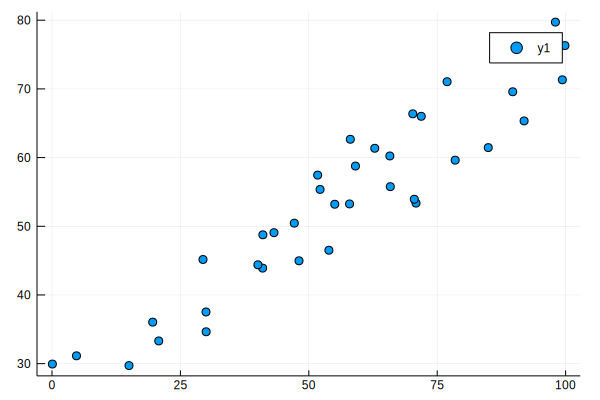

In [144]:
scatter(xdata, ydata)

In [145]:
function log_prior(theta)
    alpha, beta, sigma = theta
    if sigma < 0
        return -Inf   # log(0)
    else
        return -0.5 * log(1 + beta^2) - log(sigma)  #Jeffreys prior for slopes
    end
end

log_prior (generic function with 1 method)

In [146]:
function log_like(theta, xvec)
    alpha, beta, sigma = theta
    #theta are parameters of the model
    #xvec are data
    x = xvec[1]
    y = xvec[2]
    y_model = alpha .+ beta .* x
    return -0.5 * sum(log(2*pi*sigma^2) .+ (y - y_model).*(y - y_model) / sigma^2)
    #return y - y_model
end

log_like (generic function with 1 method)

In [147]:
function log_posterior(theta, xvec)
    return log_prior(theta) + log_like(theta,xvec)
end

log_posterior (generic function with 1 method)

In [148]:
# set up some standard values
guess = [30.0 0.6 10.0] # initial guess for intercept, slope, noise rms
nrun = 50000 # number to run in chain
nburn = 5000 # number to ignore (later)

5000

In [149]:
res = mslicer(log_posterior, 3, guess, [xdata, ydata], N=nrun);

In [150]:
A_chain = res[nburn:end,1]
B_chain = res[nburn:end,2]
N_chain = res[nburn:end,3];

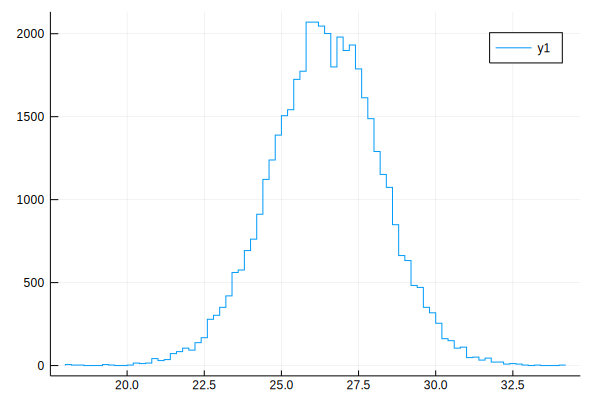

In [151]:
stephist(A_chain)

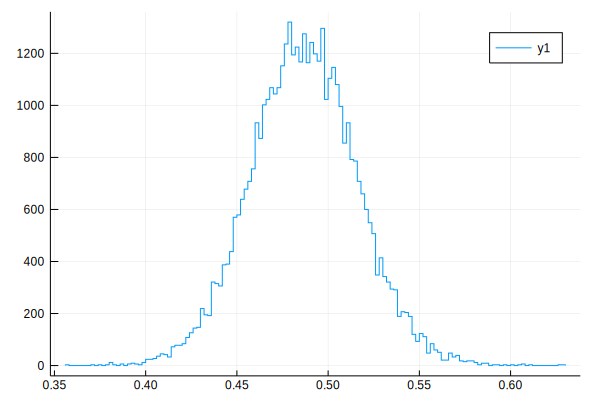

In [152]:
stephist(B_chain)

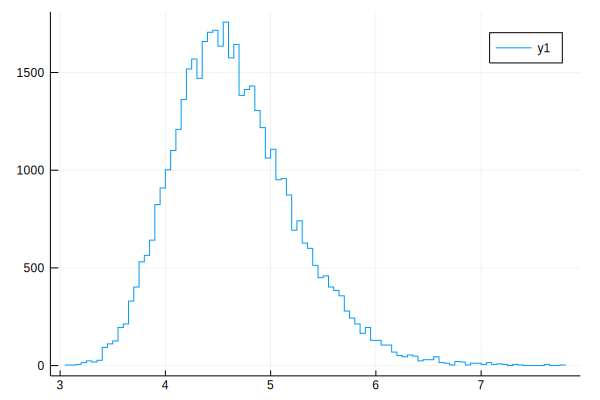

In [153]:
stephist(N_chain)

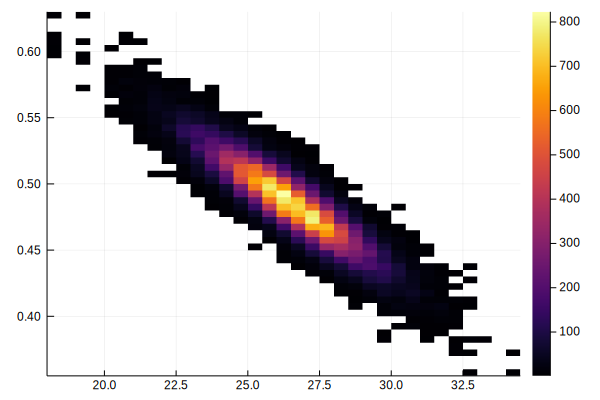

In [154]:
histogram2d(A_chain,B_chain)

## Looking at the maximum parts of the log-posterior likelihood
Now let's try to get the log-likelihood values of the chain. It would likely be more efficient to return them as part of `mslicer` return values, but I will not worry about that right now.

But if  you look at the results below, you see that the maximum log-likelihood values are not really the "center" of your distribution derived from the Markov chain.  One should look for how to find the location of a multi-parameter distribution.




In [168]:
medA, medB, medN = median(A_chain), median(B_chain), median(N_chain)
@printf("median intercept A: %5.3f, slope B: %5.3f, noise N: %5.3f \n", medA, medB, medN)
@printf("likely interval for intercept: [%5.3f, %5.3f]\n", percentile(A_chain,5), percentile(A_chain,95))
@printf("likely interval for slope:     [%5.3f, %5.3f]\n", percentile(B_chain,5), percentile(B_chain,95))
@printf("likely interval for N:         [%5.3f, %5.3f]\n", percentile(N_chain,5), percentile(N_chain,95))

median intercept A: 26.434, slope B: 0.487, noise N: 4.594 
likely interval for intercept: [23.423, 29.368]
likely interval for slope:     [0.439, 0.535]
likely interval for N:         [3.813, 5.679]


In [155]:
# get a list of log-posterior values
ll_res = [log_posterior(res[i,:], [xdata ydata]) for i in 1:nrun]

50000-element Array{Float64,1}:
 -9.262783383805342 
 -9.237372362842867 
 -7.114539375871431 
 -7.126328190529914 
 -7.12025004055081  
 -6.917754545812792 
 -6.91234711882807  
 -6.895411493381891 
 -5.868578207327461 
 -5.859614467115195 
 -5.952682659499542 
 -6.153240183031292 
 -6.119090682818997 
  ⋮                 
 -8.539664943898746 
 -7.756320157063897 
 -7.1508167055621366
 -8.242278717065632 
 -8.52576014442341  
 -8.501484438326356 
 -7.662030448232476 
 -7.844275716209834 
 -8.47019231210463  
 -8.121547293248113 
 -9.05641478764292  
 -9.261172519703274 

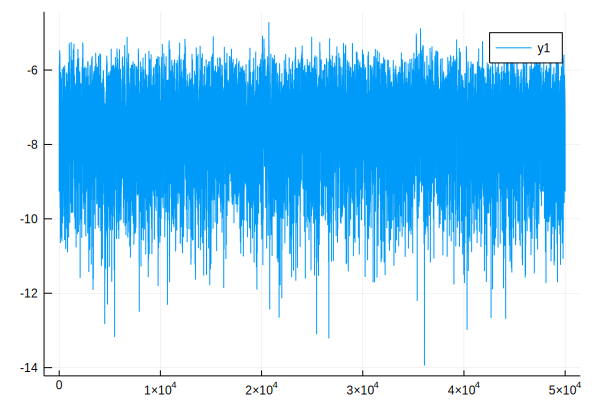

In [156]:
plot(ll_res)

In [169]:
percentile(ll_res, 99) # the best 1%

-5.678442837144657

In [170]:
# the magical findall function
goodies = findall(x -> x > -28, ll_res) #find a set of the likelier values
goodest = findmax(ll_res) # the highest log-posterior


(-4.7114271613974905, 20720)

In [171]:
res[20720,:]

3-element Array{Float64,1}:
 29.913592530117334  
  0.38146512016888956
  5.051185727028583  

In [123]:
gg = [res[j,k] for j in goodies, k in 1:3]

14×3 Array{Float64,2}:
 26.29    0.459681  10.0104 
 26.29    0.459681   9.90432
 26.0924  0.459681   9.90432
 26.0924  0.461104   9.90432
 21.4343  0.502232   9.14122
 29.3629  0.427103   9.27   
 28.1198  0.427103   9.27   
 28.1198  0.407088   9.27   
 28.1198  0.407088   9.44099
 27.8171  0.407088   9.44099
 27.8171  0.418174   9.44099
 27.8171  0.418174   9.64271
 26.6289  0.418174   9.64271
 26.6289  0.417382   9.64271

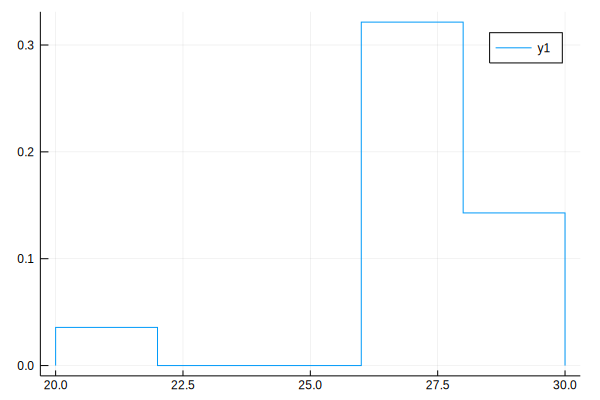

In [124]:
stephist(gg[:,1], normalized=true)

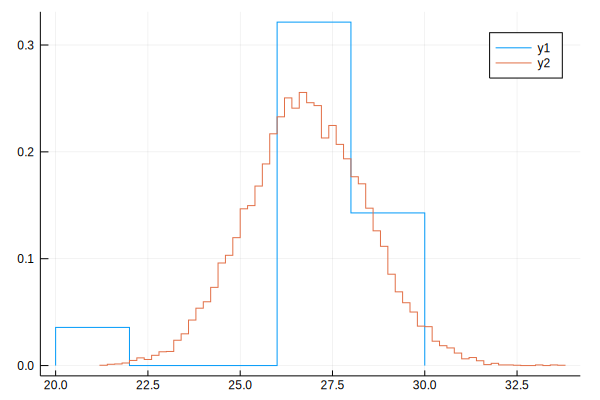

In [125]:
stephist!(res[:,1], normalized=true)